# Micromagnetic model

## Mesh

The mesh is defined by three parameters:

1. points `p1` and `p2` between which the mesh domain spans,
2. discretisation cell size `cell`.

There is also an optional `name` argument. For instance, if the mesh spans between `p1 = (0, 0, 0)` and `p2 = (100e-9, 100e-9, 10e-9)` and the discretisation cell is `cell = (5e-9, 5e-9, 5e-9)`, we create the mesh as:

In [1]:
import oommfc as oc

mesh = oc.Mesh(p1=(0, 0, 0), p2=(100e-9, 100e-9, 10e-9), cell=(10e-9, 10e-9, 10e-9), name="mesh")
mesh

The domain edge lengths in x, y, and z directions are:

In [2]:
mesh.l

(1e-07, 1e-07, 1e-08)

The number of cells in all three directions:

In [3]:
mesh.n

(10, 10, 1)

The centre point of the mesh:

In [4]:
mesh.centre

(5e-08, 5e-08, 5e-09)

To show the mesh domain and discretisation cell:

In [5]:
mesh

If we want to iterate through all mesh coordinates, there is `coordinates` generator:

In [6]:
for coord in mesh.coordinates():
    print(coord)

(5e-09, 5e-09, 5e-09)
(1.5000000000000002e-08, 5e-09, 5e-09)
(2.5e-08, 5e-09, 5e-09)
(3.5e-08, 5e-09, 5e-09)
(4.5e-08, 5e-09, 5e-09)
(5.5e-08, 5e-09, 5e-09)
(6.5e-08, 5e-09, 5e-09)
(7.5e-08, 5e-09, 5e-09)
(8.500000000000001e-08, 5e-09, 5e-09)
(9.5e-08, 5e-09, 5e-09)
(5e-09, 1.5000000000000002e-08, 5e-09)
(1.5000000000000002e-08, 1.5000000000000002e-08, 5e-09)
(2.5e-08, 1.5000000000000002e-08, 5e-09)
(3.5e-08, 1.5000000000000002e-08, 5e-09)
(4.5e-08, 1.5000000000000002e-08, 5e-09)
(5.5e-08, 1.5000000000000002e-08, 5e-09)
(6.5e-08, 1.5000000000000002e-08, 5e-09)
(7.5e-08, 1.5000000000000002e-08, 5e-09)
(8.500000000000001e-08, 1.5000000000000002e-08, 5e-09)
(9.5e-08, 1.5000000000000002e-08, 5e-09)
(5e-09, 2.5e-08, 5e-09)
(1.5000000000000002e-08, 2.5e-08, 5e-09)
(2.5e-08, 2.5e-08, 5e-09)
(3.5e-08, 2.5e-08, 5e-09)
(4.5e-08, 2.5e-08, 5e-09)
(5.5e-08, 2.5e-08, 5e-09)
(6.5e-08, 2.5e-08, 5e-09)
(7.5e-08, 2.5e-08, 5e-09)
(8.500000000000001e-08, 2.5e-08, 5e-09)
(9.5e-08, 2.5e-08, 5e-09)
(5e-09, 3

## System

The basic block of our micromagnetic model is the system object. It is fully defined if:

1. Hamiltonian,
2. dynamics equation,
3. magnetisation.

are provided. The system is then "driven" in phase space using particular drivers.

In [7]:
system = oc.System(name="system")

## Hamiltonian

In [8]:
exchange = oc.Exchange(A=1e-12)

In [9]:
exchange

Exchange(A=1e-12)

In [10]:
exchange.A

1e-12

In [11]:
repr(exchange)

'Exchange(A=1e-12)'

In [12]:
hamiltonian = exchange + oc.Zeeman(H=(1e6, 0, 0))

type(hamiltonian)

oommfc.hamiltonian.hamiltonian.Hamiltonian

In [13]:
system.hamiltonian = hamiltonian

In [14]:
system.hamiltonian

Exchange(A=1e-12) + Zeeman(H=(1000000.0, 0, 0))

In [15]:
system.hamiltonian.exchange.A

1e-12

In [16]:
system.hamiltonian.zeeman.H

(1000000.0, 0, 0)

In [17]:
system.hamiltonian += oc.Demag(name="energy_term_name")

In [18]:
system.hamiltonian.energy_term_name

Demag()

## Dynamics

In [19]:
system.dynamics = oc.Precession(gamma=2.211e5) + oc.Damping(alpha=0.1)

In [20]:
system.dynamics

Precession(gamma=221100.0) + Damping(alpha=0.1)

## Magnetisation

In [21]:
import discretisedfield as df

In [22]:
Ms = 8e5
m = df.Field(mesh, value=(1, 0, 1), norm=Ms, name="m")

In [23]:
m  # representation to be decided

Field(dim=3, name="m")

In [24]:
p = (50e-9, 50e-9, 5e-9)
m(p)  # sampling

array([ 565685.42494924,       0.        ,  565685.42494924])

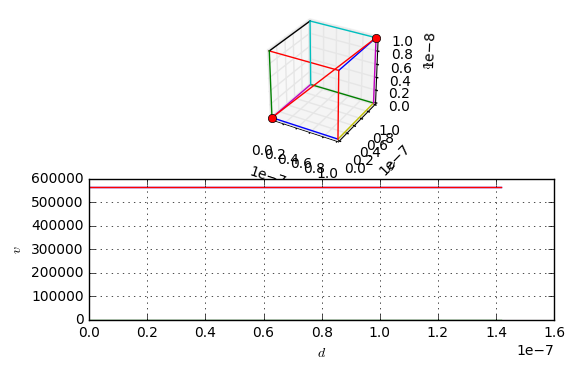

In [25]:
%matplotlib inline
fig = m.plot_line_intersection(l=(100, 100, 10), l0=(0, 0, 0))

In [26]:
m.f = lambda pos: (pos[0]+pos[2]+1, pos[2], 0)

In [27]:
system.m = m

## Drivers

### MinDriver

In [28]:
md = oc.MinDriver()
md.drive(system)

In [29]:
system.m.average

(799861.70786876988, 2.9103830456733704e-13, 0.00016761849547198681)

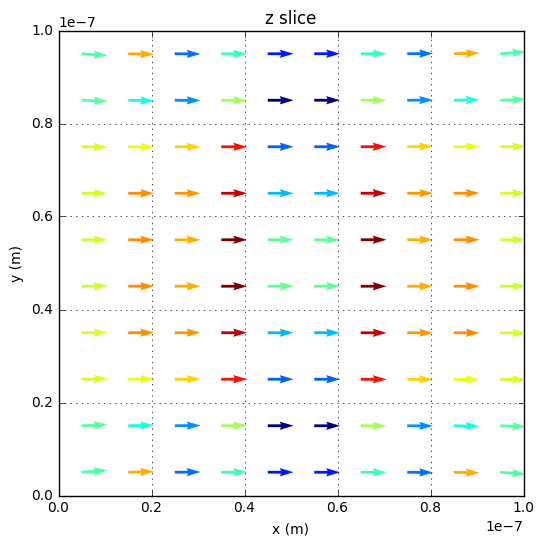

In [30]:
fig = system.m.plot_slice("z", 5e-9, xsize=6)

In [31]:
system.hamiltonian.zeeman.H = (0, 1e7, 0)

In [32]:
md.drive(system)

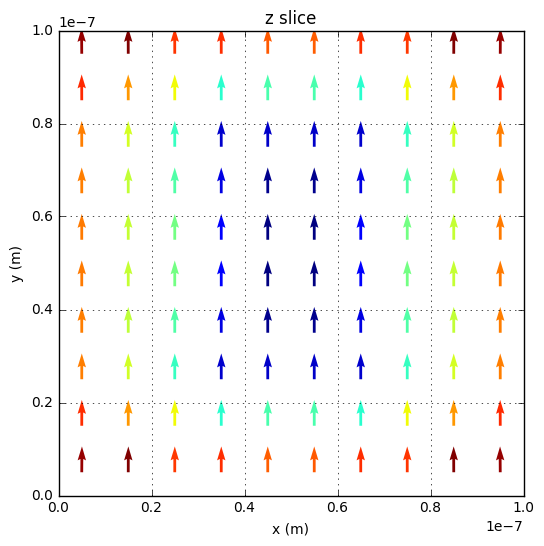

In [33]:
fig = system.m.plot_slice("z", 5e-9, xsize=6)

### Time driver

In [34]:
system.hamiltonian += oc.UniaxialAnisotropy(K=5e3, u=(0, 0, 1))
system.hamiltonian.zeeman.H = (1e6, 0, 0)

In [35]:
td = oc.TimeDriver()
td.drive(system, t=0.2e-9, n=50)

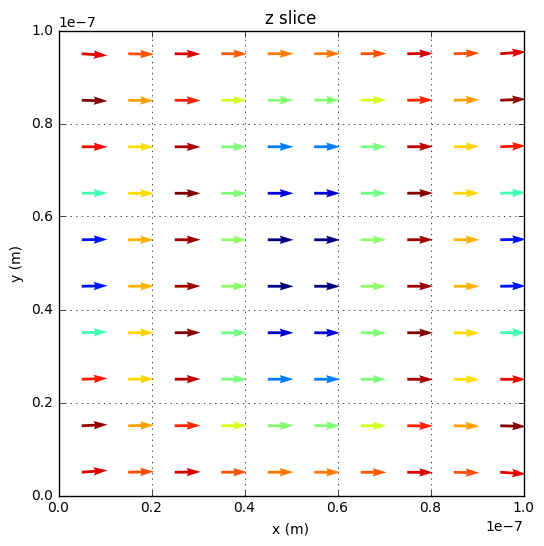

In [36]:
fig = system.m.plot_slice("z", 5e-9, xsize=6)

In [37]:
system.dt

,E,Ecount,max_dm/dt,dE/dt,deltaE,Eex,max_spin_angle,stage_max_spin_angle,run_max_spin_angle,FixedZeeman:zeeman:Energy,Ed,Ea,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,-4.971104e-18,49.0,14057.666435,-2.578686e-06,-2.528730e-18,1.252607e-21,4.125459,4.125459,4.125459,-2.484413e-17,1.964881e-17,2.229652e-19,8.0,8.0,0.0,0.247129,0.619206,0.744268,1.005839e-12,4.000000e-12
1,-1.583953e-17,62.0,14474.714493,-2.708355e-06,-5.303152e-18,4.084886e-21,7.412512,7.412512,7.412512,-4.079416e-17,2.482185e-17,1.286896e-19,11.0,2.0,1.0,0.405787,-0.297709,0.861196,1.925873e-12,8.000000e-12
2,-2.543710e-17,75.0,13233.511815,-2.064454e-06,-3.576661e-18,4.184327e-21,7.337951,7.412512,7.412512,-3.148713e-17,5.577760e-18,4.680859e-19,14.0,2.0,2.0,0.313208,-0.915132,0.243315,1.632482e-12,1.200000e-11
3,-3.360761e-17,88.0,13099.959436,-2.204825e-06,-3.420178e-18,6.276926e-21,9.577521,9.577521,9.577521,-4.581115e-17,1.183394e-17,3.633244e-19,17.0,2.0,3.0,0.455692,-0.717423,-0.519158,1.625403e-12,1.600000e-11
4,-4.310056e-17,101.0,13547.596427,-2.374234e-06,-3.869850e-18,1.519146e-20,14.358989,14.358989,14.358989,-6.334196e-17,2.001349e-17,2.127187e-19,20.0,2.0,4.0,0.630074,0.102425,-0.757073,1.597991e-12,2.000000e-11
5,-5.119846e-17,114.0,12116.859576,-1.635911e-06,-2.817518e-18,2.049299e-20,18.020651,18.020651,18.020651,-5.814007e-17,6.471832e-18,4.492824e-19,23.0,2.0,5.0,0.578330,0.746072,-0.290307,1.580947e-12,2.400000e-11
6,-5.732008e-17,127.0,11810.480069,-1.604258e-06,-2.350551e-18,2.412267e-20,19.921844,19.921844,19.921844,-6.613584e-17,8.369575e-18,4.220608e-19,26.0,2.0,6.0,0.657865,0.635767,0.365731,1.524089e-12,2.800000e-11
7,-6.417422e-17,140.0,11982.354487,-1.685143e-06,-2.550500e-18,3.875910e-20,24.440849,24.440849,24.440849,-7.818518e-17,1.364622e-17,3.259818e-19,29.0,2.0,7.0,0.777722,-0.041183,0.587646,1.470635e-12,3.200000e-11
8,-6.974612e-17,153.0,10543.768892,-1.094236e-06,-1.561675e-18,4.549134e-20,27.078708,27.078708,27.078708,-7.607731e-17,5.823638e-18,4.620604e-19,32.0,2.0,8.0,0.756755,-0.568718,0.227358,1.321711e-12,3.600000e-11
9,-7.381886e-17,166.0,10004.943987,-1.056150e-06,-1.355884e-18,4.434775e-20,26.832555,27.078708,27.078708,-8.137292e-17,7.068903e-18,4.408104e-19,35.0,2.0,9.0,0.809431,-0.469866,-0.271833,1.321130e-12,4.000000e-11


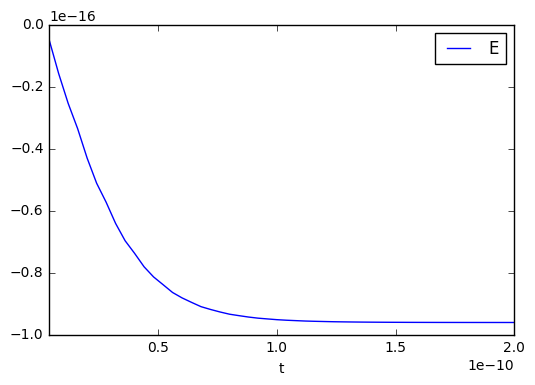

In [38]:
system.dt.plot("t", "E")